# Exercise 3 (Tutorial 10-11)

Dataset: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/data

## Task 1: Dependency-based Parsing
Source: https://towardsdatascience.com/natural-language-processing-dependency-parsing-cf094bbbe3f7/

Import Libraries and Load Data

In [4]:
import pandas as pd
import spacy
from spacy import displacy
import numpy as np
from textblob import TextBlob
from collections import defaultdict, Counter
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

df = pd.read_csv('tripadvisor_hotel_reviews.csv')
print(f"Dataset shape: {df.shape}")


Dataset shape: (20491, 2)


Sentiment Lexicon

In [7]:
# Using TextBlob's built-in sentiment polarity for simplicity
def get_sentiment_score(text):
    """Get sentiment polarity using TextBlob"""
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns value between -1 (negative) and 1 (positive)

# Test the sentiment function
sample_text = "The food was amazing and the service was terrible"
print(f"Sample text: {sample_text}")
print(f"Sentiment score: {get_sentiment_score(sample_text)}")

Sample text: The food was amazing and the service was terrible
Sentiment score: -0.19999999999999996


Dependency Parsing Function

In [8]:
def analyze_dependencies(text):
    """
    Analyze dependencies and extract opinion-target pairs
    """
    doc = nlp(text)
    
    # Store dependency information
    dependencies = []
    
    print(f"Text: {text}")
    print("-" * 80)
    print(f"{'Token':<15} | {'POS':<8} | {'Dependency':<12} | {'Head':<15} | {'Children'}")
    print("-" * 80)
    
    for token in doc:
        children = [child.text for child in token.children]
        dependencies.append({
            'token': token.text,
            'pos': token.pos_,
            'dep': token.dep_,
            'head': token.head.text,
            'children': children
        })
        
        print(f"{token.text:<15} | {token.pos_:<8} | {token.dep_:<12} | {token.head.text:<15} | {children}")
    
    return dependencies, doc

# Test with a sample review
sample_review = df['Review'].iloc[0][:200]  # First 200 chars of first review
dependencies, doc = analyze_dependencies(sample_review)

Text: nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room roo
--------------------------------------------------------------------------------
Token           | POS      | Dependency   | Head            | Children
--------------------------------------------------------------------------------
nice            | ADJ      | amod         | parking         | []
hotel           | NOUN     | nmod         | parking         | []
expensive       | ADJ      | amod         | parking         | []
parking         | NOUN     | nsubj        | got             | ['nice', 'hotel', 'expensive']
got             | VERB     | ROOT         | got             | ['parking', 'stay', ',', 'arrived', 'took']
good            | ADJ      | amod         | deal            | []
deal            | NOUN     | nsubj        | stay            | ['good']
stay            | VERB     | c

Extract Opinion-Target Pairs

In [9]:
def extract_opinion_target_pairs(text):
    """
    Extract opinion words and their targets using dependency parsing
    """
    doc = nlp(text)
    pairs = []
    
    for token in doc:
        # Look for adjectives that might be opinions
        if token.pos_ == 'ADJ':
            # Find what the adjective is describing
            if token.dep_ == 'amod':  # Adjectival modifier
                target = token.head.text
                opinion = token.text
                pairs.append((opinion, target))
        
        # Look for verbs with objects (another opinion pattern)
        elif token.pos_ == 'VERB':
            objects = [child.text for child in token.children if child.dep_ == 'dobj']
            if objects:
                for obj in objects:
                    pairs.append((token.text, obj))
    
    return pairs

# Test opinion-target extraction
sample_pairs = extract_opinion_target_pairs(sample_review)
print("Opinion-Target Pairs:")
for opinion, target in sample_pairs:
    print(f"  Opinion: '{opinion}' -> Target: '{target}'")

Opinion-Target Pairs:
  Opinion: 'nice' -> Target: 'parking'
  Opinion: 'expensive' -> Target: 'parking'
  Opinion: 'good' -> Target: 'deal'
  Opinion: 'late' -> Target: 'evening'
  Opinion: 'took' -> Target: 'advice'
  Opinion: 'took' -> Target: 'reviews'
  Opinion: 'took' -> Target: 'parking'
  Opinion: 'previous' -> Target: 'reviews'
  Opinion: 'valet' -> Target: 'parking'
  Opinion: 'check' -> Target: 'roo'
  Opinion: 'quick' -> Target: 'easy'
  Opinion: 'easy' -> Target: 'room'
  Opinion: 'disappointed' -> Target: 'room'
  Opinion: 'non' -> Target: 'room'
  Opinion: '-' -> Target: 'room'
  Opinion: 'existent' -> Target: 'room'


Sentiment Analysis with Dependency Parsing

In [10]:
def dependency_based_sentiment_analysis(text):
    """
    Perform sentiment analysis using dependency parsing
    """
    doc = nlp(text)
    
    # Extract opinion-target pairs
    pairs = extract_opinion_target_pairs(text)
    
    # Analyze sentiment of each pair
    sentiment_results = []
    
    for opinion, target in pairs:
        # Get sentiment of the opinion word
        opinion_sentiment = get_sentiment_score(opinion)
        
        sentiment_results.append({
            'opinion': opinion,
            'target': target,
            'sentiment_score': opinion_sentiment,
            'sentiment_label': 'positive' if opinion_sentiment > 0 else 'negative' if opinion_sentiment < 0 else 'neutral'
        })
    
    # Overall text sentiment
    overall_sentiment = get_sentiment_score(text)
    
    return {
        'text': text,
        'opinion_target_pairs': sentiment_results,
        'overall_sentiment': overall_sentiment,
        'overall_label': 'positive' if overall_sentiment > 0 else 'negative' if overall_sentiment < 0 else 'neutral'
    }

# Test the complete function
result = dependency_based_sentiment_analysis(sample_review)
print("Dependency-based Sentiment Analysis Result:")
print(f"Overall Sentiment: {result['overall_label']} (Score: {result['overall_sentiment']:.3f})")
print("\nOpinion-Target Analysis:")
for pair in result['opinion_target_pairs']:
    print(f"  '{pair['opinion']}' about '{pair['target']}': {pair['sentiment_label']} ({pair['sentiment_score']:.3f})")

Dependency-based Sentiment Analysis Result:
Overall Sentiment: positive (Score: 0.018)

Opinion-Target Analysis:
  'nice' about 'parking': positive (0.600)
  'expensive' about 'parking': negative (-0.500)
  'good' about 'deal': positive (0.700)
  'late' about 'evening': negative (-0.300)
  'took' about 'advice': neutral (0.000)
  'took' about 'reviews': neutral (0.000)
  'took' about 'parking': neutral (0.000)
  'previous' about 'reviews': negative (-0.167)
  'valet' about 'parking': neutral (0.000)
  'check' about 'roo': neutral (0.000)
  'quick' about 'easy': positive (0.333)
  'easy' about 'room': positive (0.433)
  'disappointed' about 'room': negative (-0.750)
  'non' about 'room': neutral (0.000)
  '-' about 'room': neutral (0.000)
  'existent' about 'room': neutral (0.000)


Apply to Multiple Reviews

In [12]:
percent = 30  # Change this to 10, 50, 100, etc.
sample_reviews = df.sample(frac=percent/100, random_state=42)  # Sample the dataset

results = []
for idx, row in sample_reviews.iterrows():
    review_text = row['Review']
    actual_rating = row['Rating']
    

    
    analysis = dependency_based_sentiment_analysis(review_text)
    
    results.append({
        'review_id': idx,
        'actual_rating': actual_rating,
        'predicted_sentiment': analysis['overall_label'],
        'sentiment_score': analysis['overall_sentiment'],
        'opinion_pairs_count': len(analysis['opinion_target_pairs'])
    })

# Display results
results_df = pd.DataFrame(results)
print("Results Summary:")
results_df

Results Summary:


,review_id,actual_rating,predicted_sentiment,sentiment_score,opinion_pairs_count
0,10726,1,negative,-0.143333,8
1,14919,4,positive,0.214394,98
2,19098,3,positive,0.620000,3
3,2450,4,positive,0.364368,84
4,960,5,positive,0.145734,21
...,...,...,...,...,...
6142,16688,5,positive,0.190278,14
6143,3290,4,positive,0.200000,11
6144,20111,4,positive,0.189451,274
6145,914,4,positive,0.210606,7


Basic Evaluation

In [13]:
# Simple evaluation based on rating mapping
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

# Add actual sentiment labels
results_df['actual_sentiment'] = results_df['actual_rating'].apply(rating_to_sentiment)

# Calculate accuracy
accuracy = (results_df['predicted_sentiment'] == results_df['actual_sentiment']).mean()
print(f"Accuracy: {accuracy:.3f}")

# Show comparison
print("\nPrediction vs Actual:")
print(results_df[['actual_rating', 'actual_sentiment', 'predicted_sentiment', 'sentiment_score']])

Accuracy: 0.791

Prediction vs Actual:
      actual_rating actual_sentiment predicted_sentiment  sentiment_score
0                 1         negative            negative        -0.143333
1                 4         positive            positive         0.214394
2                 3          neutral            positive         0.620000
3                 4         positive            positive         0.364368
4                 5         positive            positive         0.145734
...             ...              ...                 ...              ...
6142              5         positive            positive         0.190278
6143              4         positive            positive         0.200000
6144              4         positive            positive         0.189451
6145              4         positive            positive         0.210606
6146              5         positive            positive         0.193238

[6147 rows x 4 columns]


## Task 2: Unsupervised Machine Learning

Import libraries

In [ ]:
# %pip install gensim

In [ ]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azri2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azri2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preprocessing
stop_words = set(stopwords.words('english'))

# Use TripAdvisor dataset
texts = [
    [word for word in word_tokenize(str(doc).lower()) if word.isalpha() and word not in stop_words]
    for doc in df['Review'].dropna().sample(1000, random_state=42)
]

print(f"Number of processed documents: {len(texts)}")
print(f"Sample processed text: {texts[0][:10]}")  # Show first 10 words of first document

Number of processed documents: 1000
Sample processed text: ['recommend', 'hotel', 'reviewers', 'actually', 'stay', 'hotel', 'good', 'thing', 'hotel', 'location']


In [16]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(texts)

# Filter out words that appear in less than 2 documents or more than 50% of documents
dictionary.filter_extremes(no_below=2, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")
print(f"Sample document representation: {corpus[0][:5]}")  # Show first 5 word-frequency pairs

Dictionary size: 4899
Corpus size: 1000
Sample document representation: [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1)]


In [17]:
# Train LDA Model
lda_model = gensim.models.LdaModel(
    corpus, 
    num_topics=5, 
    id2word=dictionary, 
    passes=10,
    random_state=42
)

print("LDA model training completed!")
print(f"Number of topics: {lda_model.num_topics}")

LDA model training completed!
Number of topics: 5


In [18]:
# Extract topic data into a table
topic_data = []
for idx, topic in lda_model.print_topics(num_words=10):
    topic_clean = topic.replace('"', '').replace('+', '')
    keywords = [kw.split('*')[1].strip() for kw in topic_clean.split() if '*' in kw]
    topic_data.append({"Topic Number": idx, "Top Keywords": ", ".join(keywords)})

# Create DataFrame
topic_df = pd.DataFrame(topic_data)

# Display as table
print("Discovered Topics:")
display(topic_df)

Discovered Topics:


,Topic Number,Top Keywords
0,0,"beach, nice, good, pool, time, day, food, room..."
1,1,"location, good, stayed, rooms, walk, breakfast..."
2,2,"location, good, rooms, breakfast, clean, nice,..."
3,3,"resort, beach, good, food, time, people, like,..."
4,4,"service, good, stayed, nice, wonderful, locati..."


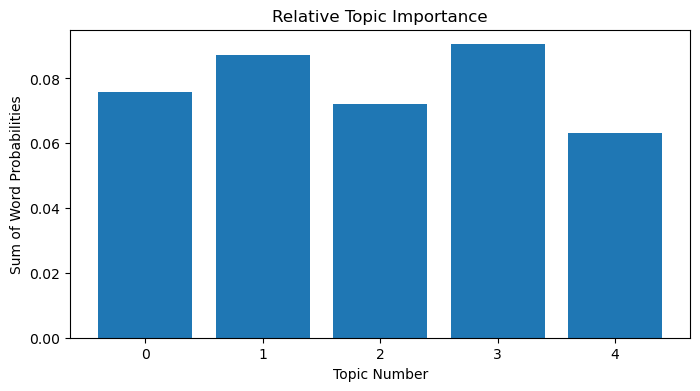

Topic weights: ['0: 0.076', '1: 0.087', '2: 0.072', '3: 0.090', '4: 0.063']


In [19]:
# Get topic importance
topic_weights = [sum([w for _, w in lda_model.get_topic_terms(i)]) for i in range(lda_model.num_topics)]

# Plot
plt.figure(figsize=(8, 4))
plt.bar(range(len(topic_weights)), topic_weights)
plt.title("Relative Topic Importance")
plt.xlabel("Topic Number")
plt.ylabel("Sum of Word Probabilities")
plt.show()

print("Topic weights:", [f"{i}: {w:.3f}" for i, w in enumerate(topic_weights)])

## Task 3: Supervised Machine Learning

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df = pd.read_csv('tripadvisor_hotel_reviews.csv')

# Use only a certain percent of the data
percent = 30  # Change this to 10, 50, 100, etc.
df = df.dropna(subset=['Review', 'Rating'])  # Remove missing values
df = df.sample(frac=percent/100, random_state=42)  # Sample the dataset

# --- Create sentiment labels from rating ---
def label_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['label'] = df['Rating'].apply(label_sentiment)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    df['Review'], df['label'], test_size=0.2, random_state=42
)

# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# --- Train Random Forest Classifier ---
model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

# --- Evaluate the model ---
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.42      0.57       194
     neutral       0.00      0.00      0.00       149
    positive       0.78      1.00      0.87       887

    accuracy                           0.78      1230
   macro avg       0.55      0.47      0.48      1230
weighted avg       0.70      0.78      0.72      1230



c:\Users\azri2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\azri2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\azri2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


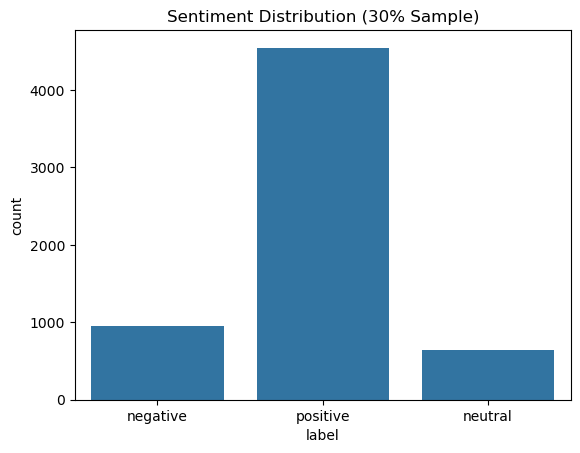

In [24]:
# --- Plot sentiment distribution ---
sns.countplot(x='label', data=df)
plt.title(f"Sentiment Distribution ({percent}% Sample)")
plt.show()
